In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, confusion_matrix, classification_report, auc, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
import os

In [2]:
# creating dataframes
test_df = ('archive_10/chest_xray/chest_xray/test')
train_df = ('archive_10/chest_xray/chest_xray/train')
val_df = ('archive_10/chest_xray/chest_xray/val')

In [3]:
# Getting the counts for each dataframe
print('Test set:')
num_pneumonia_test = len(os.listdir(os.path.join(test_df, 'PNEUMONIA')))
num_normal_test = len(os.listdir(os.path.join(test_df, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia_test}")
print(f"NORMAL={num_normal_test}")


print("Train set:")
num_pneumonia_train = len(os.listdir(os.path.join(train_df, 'PNEUMONIA')))
num_normal_train = len(os.listdir(os.path.join(train_df, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia_train}")
print(f"NORMAL={num_normal_train}")
print("\n")

print("Val set:")
num_pneumonia_val = len(os.listdir(os.path.join(val_df, 'PNEUMONIA')))
num_normal_val = len(os.listdir(os.path.join(val_df, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia_val}")
print(f"NORMAL={num_normal_val}")
print("\n")



Test set:
PNEUMONIA=390
NORMAL=234
Train set:
PNEUMONIA=3876
NORMAL=1342


Val set:
PNEUMONIA=9
NORMAL=9




Examples of a normal xray:
-------------------------------


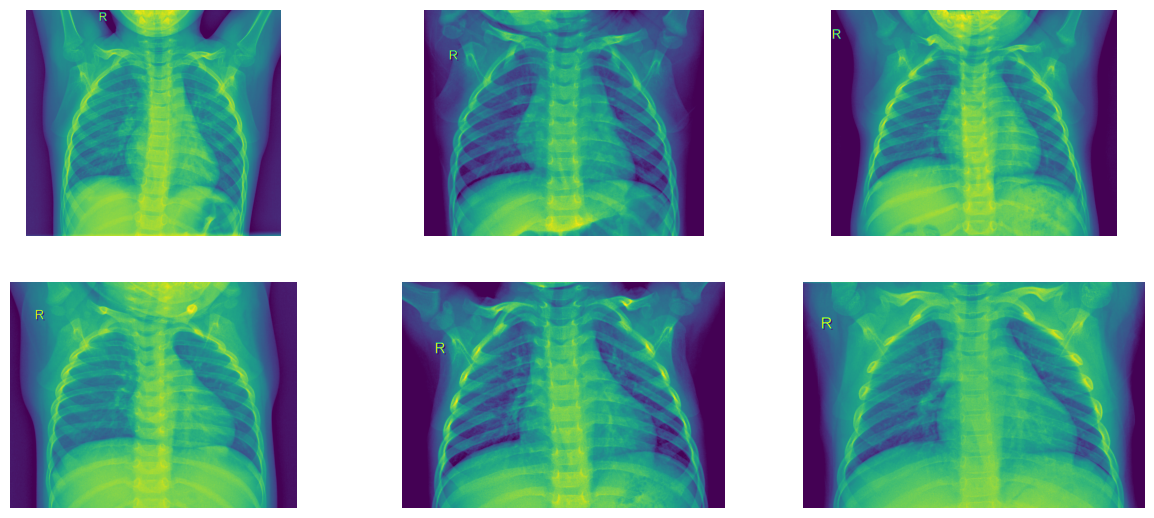

In [4]:
#Illustrating examples of a normal xray
print('Examples of a normal xray:\n-------------------------------')
normal = os.listdir('archive_10/chest_xray/train/NORMAL')
normal_directory = 'archive_10/chest_xray/train/NORMAL'

plt.figure(figsize = (15,10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_directory, normal[i]))
    plt.imshow(img)
    plt.axis('off')

Examples of a pneumonia xray:
----------------------


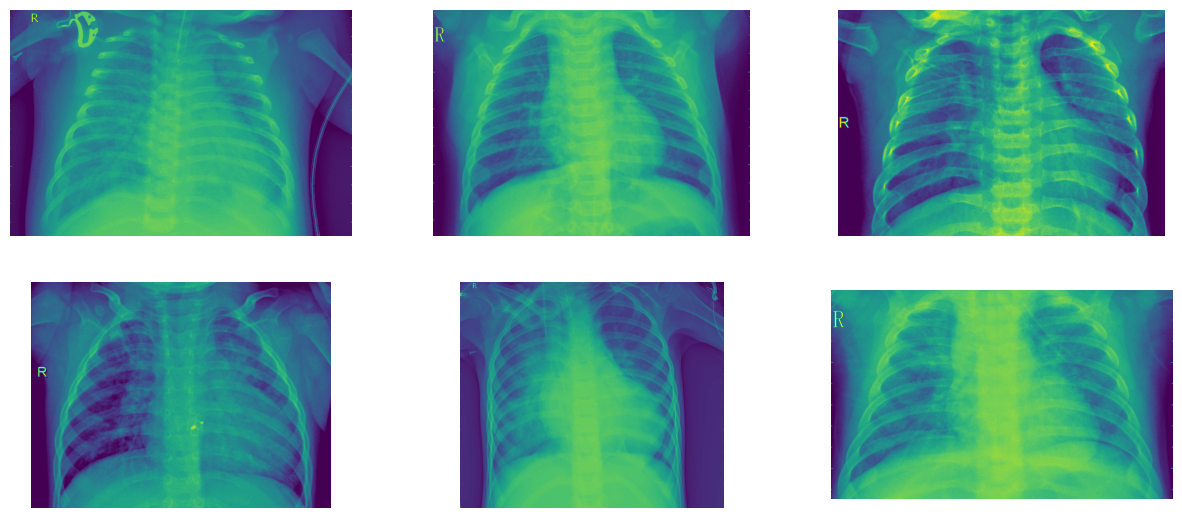

In [5]:
#illustrating examples of a pneumonia xray
print('Examples of a pneumonia xray:\n----------------------')
pneumonia = os.listdir('archive_10/chest_xray/train/PNEUMONIA')
pneumonia_directory = 'archive_10/chest_xray/train/PNEUMONIA'

plt.figure(figsize = (15,10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_directory, pneumonia[i]))
    plt.imshow(img)
    plt.axis('off')

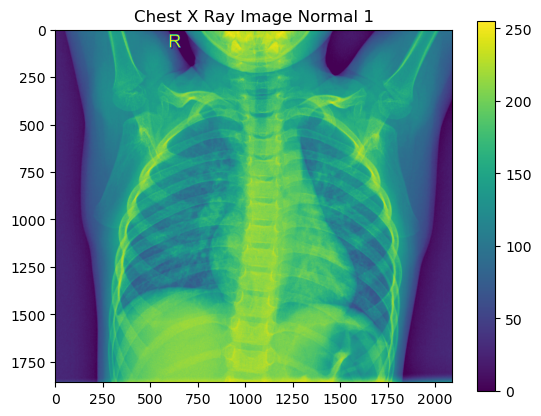

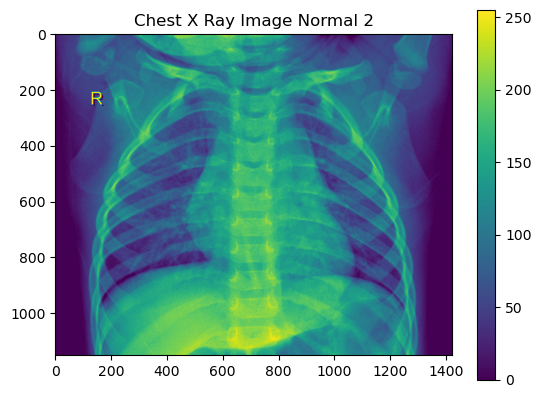

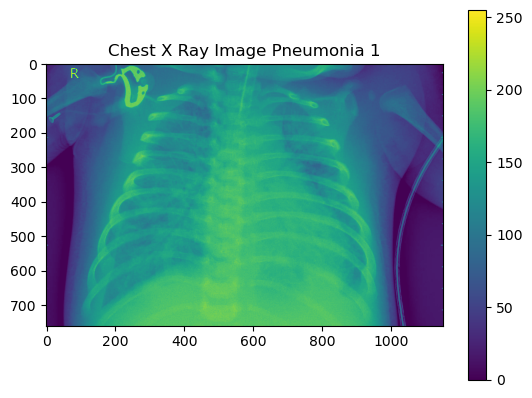

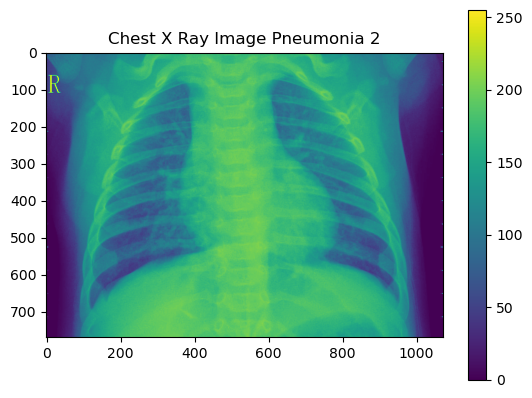

In [7]:
norm_1 = os.listdir("archive_10/chest_xray/train/NORMAL")[0]
norm_2 = os.listdir("archive_10/chest_xray/train/NORMAL")[1]
pnu_1 = os.listdir("archive_10/chest_xray/train/PNEUMONIA")[0]
pnu_2 = os.listdir("archive_10/chest_xray/train/PNEUMONIA")[1]


sample_norm_1 = plt.imread(os.path.join(normal_directory, norm_1))
sample_norm_2 = plt.imread(os.path.join(normal_directory, norm_2))
sample_pnu_1 = plt.imread(os.path.join(pneumonia_directory, pnu_1))
sample_pnu_2 = plt.imread(os.path.join(pneumonia_directory, pnu_2))

plt.imshow(sample_norm_1)
plt.colorbar()
plt.title('Chest X Ray Image Normal 1')
plt.show()
plt.imshow(sample_norm_2)
plt.colorbar()
plt.title('Chest X Ray Image Normal 2')
plt.show()
plt.imshow(sample_pnu_1)
plt.colorbar()
plt.title('Chest X Ray Image Pneumonia 1')
plt.show()
plt.imshow(sample_pnu_2)
plt.colorbar()
plt.title('Chest X Ray Image Pneumonia 2')
plt.show()

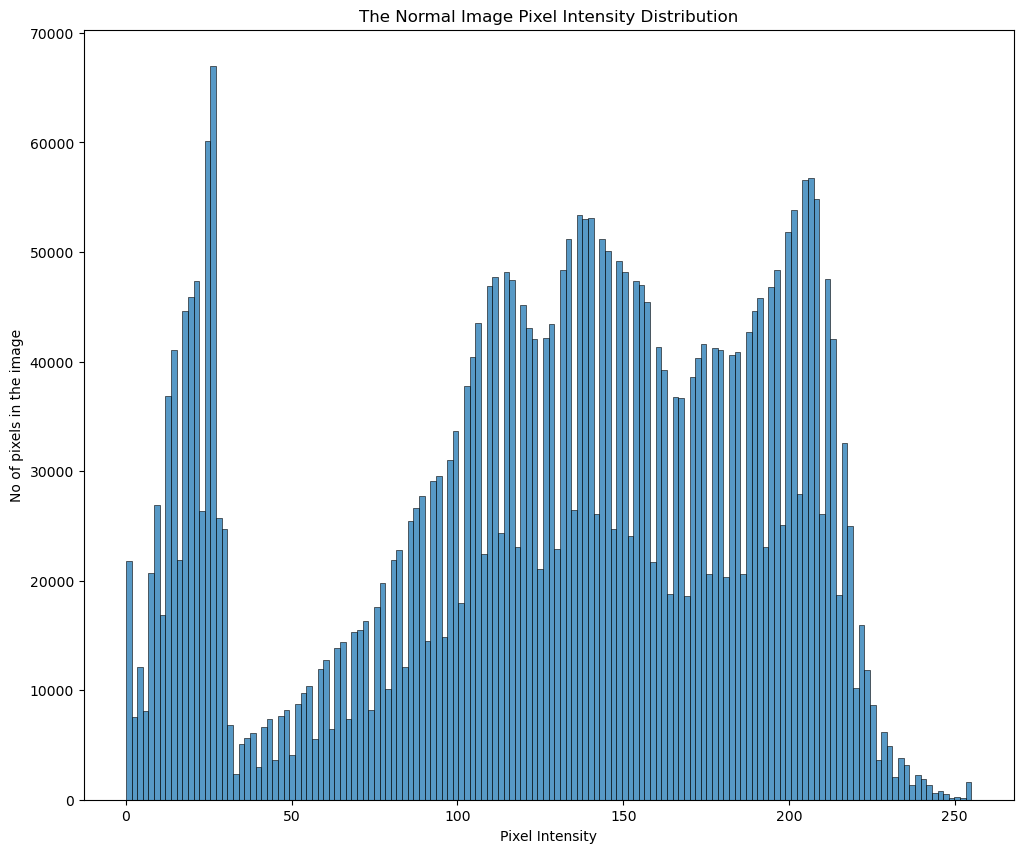

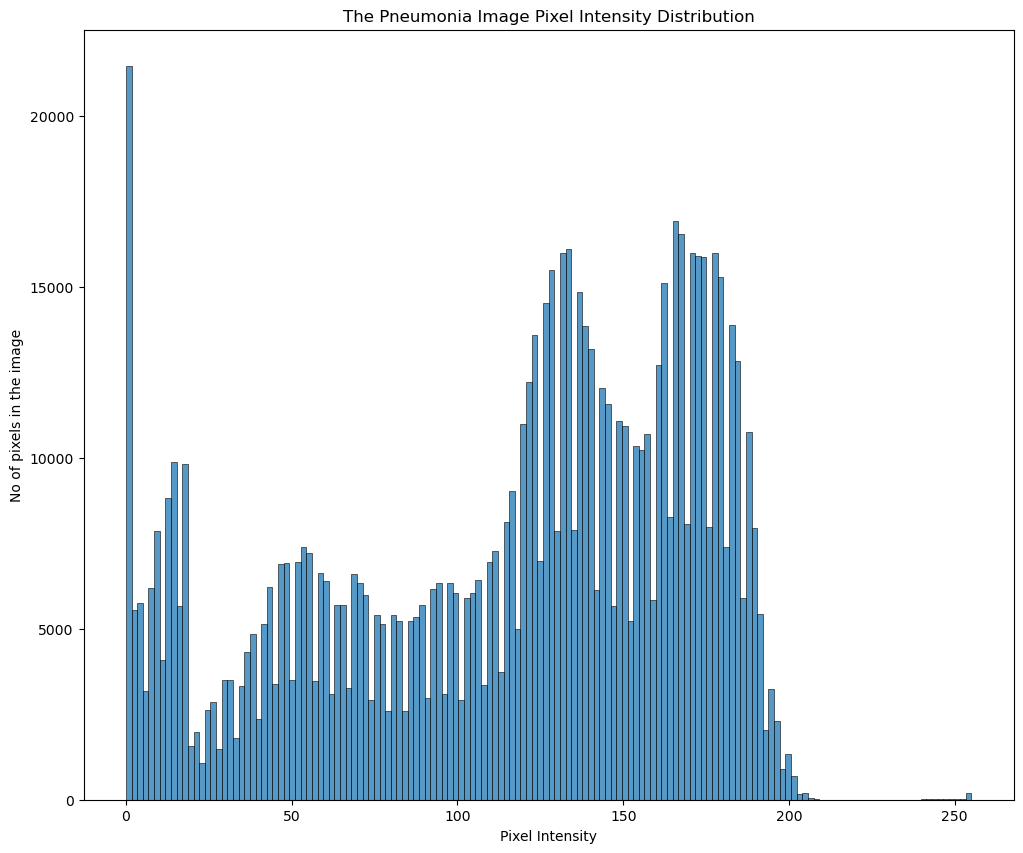

In [9]:
#plotting pixel intensities
def plot_image_histogram(img_1, img_2):
    fig, ax = plt.subplots(figsize = (12, 10))
    sns.histplot(img_1.ravel(), bins = 150,)
    plt.title('The Normal Image Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('No of pixels in the image')
    plt.show()
    
    fig, ax = plt.subplots(figsize = (12, 10))
    sns.histplot(img_2.ravel(), bins = 150)
    plt.title('The Pneumonia Image Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('No of pixels in the image')
    plt.show()

plot_image_histogram(sample_norm_1, sample_pnu_1)

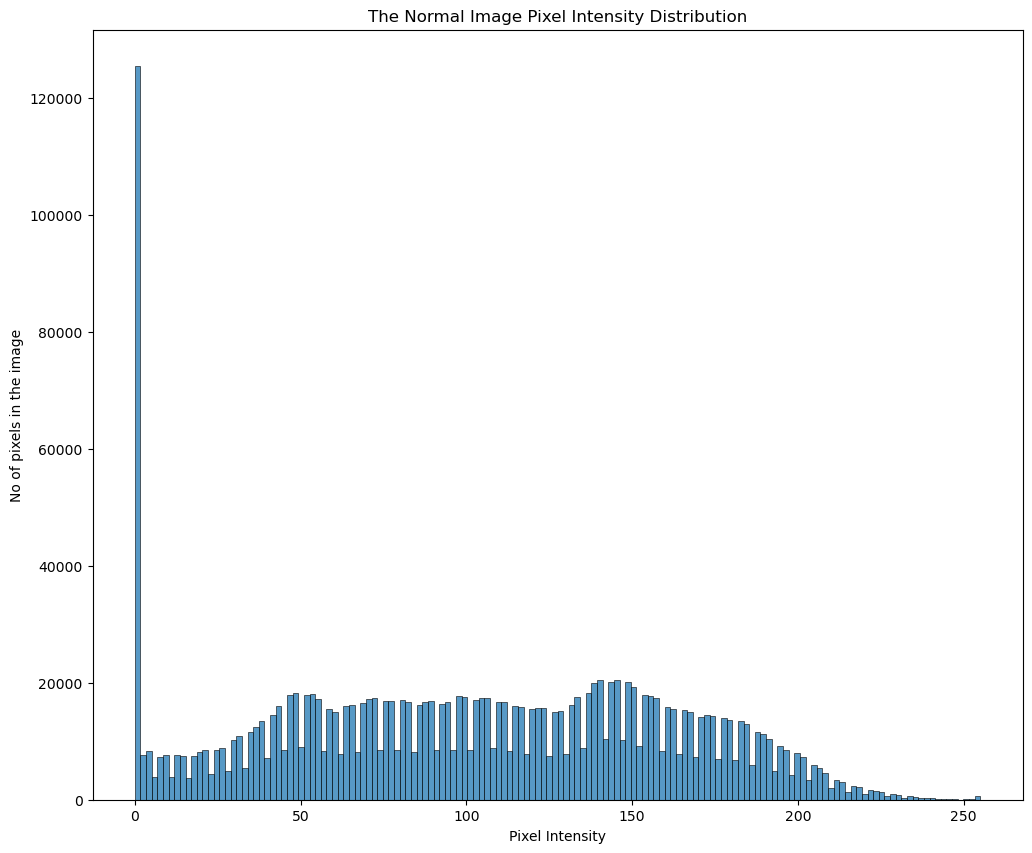

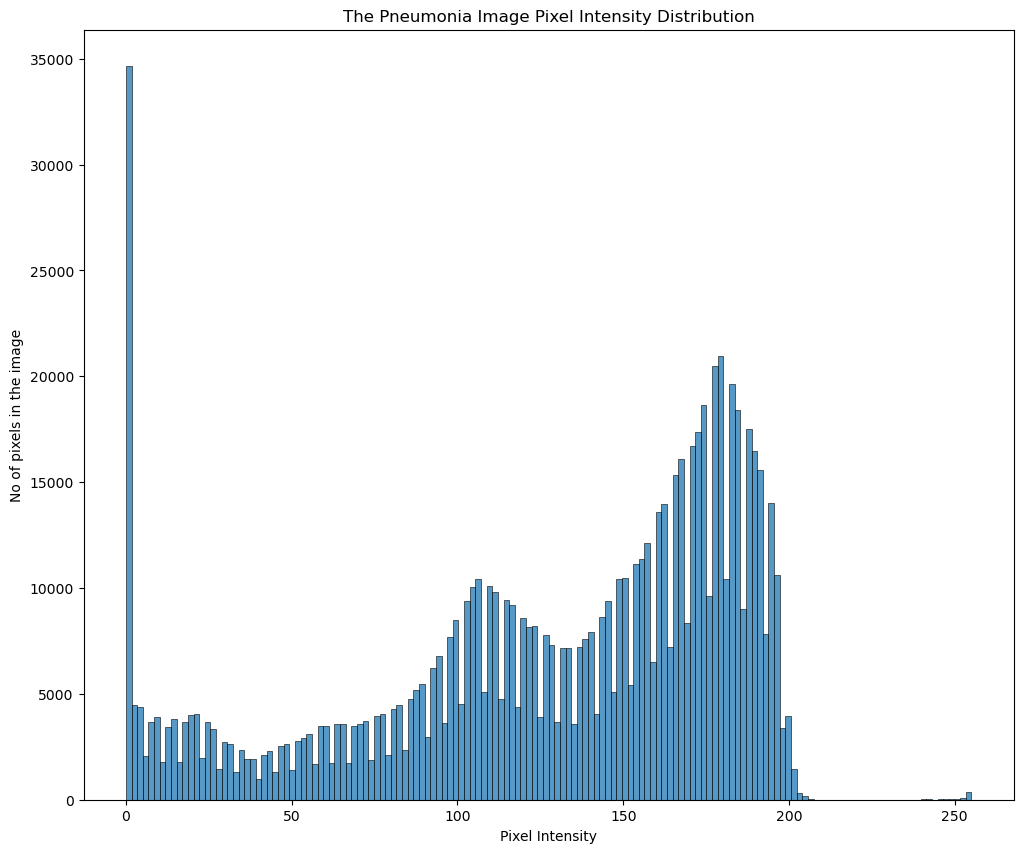

In [10]:
plot_image_histogram(sample_norm_2, sample_pnu_2)

In [11]:
#data nomarilization
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

#Using a generator for the images to work with.
train_generator = train_datagen.flow_from_directory(train_df,
                                                   target_size = (224, 224),
                                                   batch_size=32,
                                                   class_mode = 'binary',
                                                   shuffle=True)

validation_generator = val_datagen.flow_from_directory(val_df,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      class_mode = 'binary',
                                                      shuffle=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
#information classification check
train_generator.class_indices
validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
num_pneumonia = 3876
num_normal = 1342
#Calculating class weights to deal with data imbalance
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia) 
weight_for_1 = num_normal / (num_normal + num_pneumonia)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [16]:
#Creating function to evaluate training loss and validation loss 
def evaluate_nn(history):
    '''
    This function plots the training accuracy, validation accuracy, training loss and validation loss from a fitted keras model.
    It gets this information from the history.history and the metric attributed to the model.
    
    '''
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'blue', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'blue', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'orange', label= 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [17]:
#Creating function to get a confusion matrix
def get_predictions(model, generator):
    '''
    This function gets the predictions from a model using a generator and gathers the true values along with the 
    predicted values to be inputted into any function that needs label(true values) and prediction(predicted) values. This
    functions serves as a way to work with generators that have shuffle = True turned on.
    '''
    
    '''
    source: https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict
    -generator/67282636#67282636
    
    '''
    
    # Create lists for storing the predictions and labels
    predictions = []
    labels = []

    # Get the total number of labels in generator 
    # (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

    # Loop over the generator
    for data, label in generator:
        # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

        # Store corresponding labels
        labels.extend(label)

        # We have to break out from the generator when we've processed 
        # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
    return labels, predictions

In [18]:
#Creating a function to plot 
def plot_confusion_matrix(y_true, y_pred):
    '''
    This function plots a regular confusion matrix. It takes predictions generated from the get_predictions
    function and calculates true positive, false positive, true negative and false negative counts.
    
    '''
    #Converting probabilities to 0 and 1
    y_pred = np.array([round(x) for x in y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();

In [19]:
#Creating a function to plot 
def plot_confusion_matrix_normalized(y_true, y_pred):
    
    #Converting probabilities to 0 and 1
    y_pred = np.array([round(x) for x in y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    '''
    This function plots a normalized confusion matrix. It takes predictions generated from the get_predictions
    functionand calculates true positive, false positive, true negative and false negative counts. It then turns the 
    confusion matrix counts into percentages for easier intepretation.
    
    '''
    #Calculating normalization
    row_sums = cm.sum(axis=1)
    new_matrix = np.round(cm / row_sums[:, np.newaxis], 3)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(new_matrix, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();

In [20]:
def plot_roc_auc(y_true, y_score):
    """
    This function plots an ROC curve and gives the AUC score of a model's predictions and a generator's true labels.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [21]:
#Initializing Model
model_1 = models.Sequential()

#Adding CNN input layer
model_1.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model_1.add(layers.MaxPooling2D(2,2))

#Adding Dense hidden layer
model_1.add(layers.Flatten())
model_1.add(layers.Dense(256, activation = 'relu'))

#Adding output layer with sigmoid for binary classification
model_1.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling the model
model_1.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.RMSprop(lr=1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

#Checking model summary to see how many params will be trained
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 256)               100933888 
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 100935041 (385.04 MB)
Trainable params: 100935041 (385.04 MB)
Non-trainable params: 0 (0.00 Byte)
__________